データを検索中...
見つかったファイル数: 30
データをダウンロード中...


Files Downloaded: 100%|██████████| 30/30 [00:05<00:00,  5.54file/s]


画像ファイルを読み込み中...
差分画像を作成中...


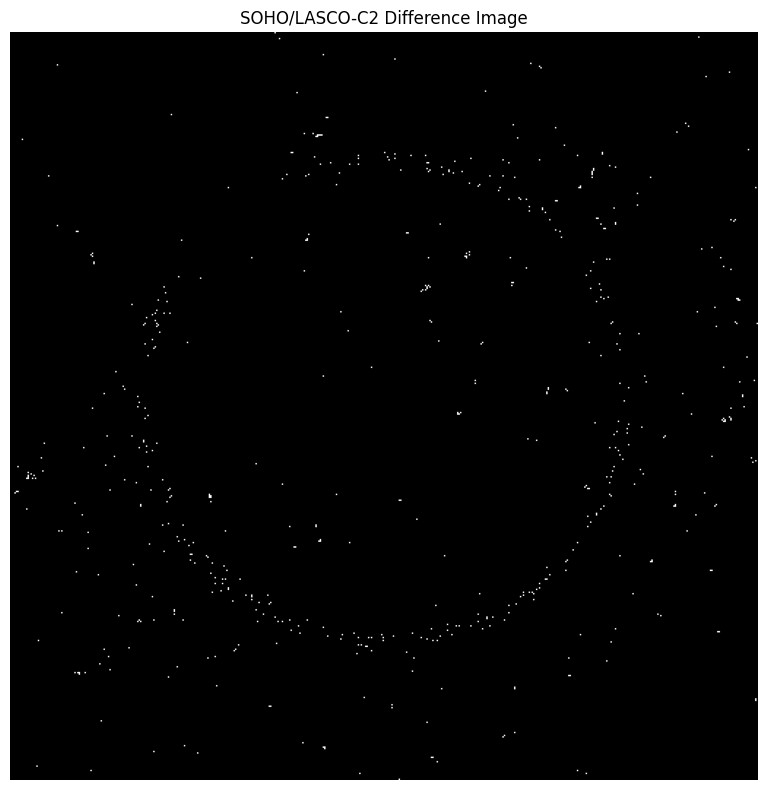

動画を作成中...
動画が作成されました: lasco_c2_diff.mp4


In [2]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt  # オプション（差分画像の確認用）
from sunpy.net import Fido, attrs as a
import sunpy.map
import warnings
from astropy.io.fits.verify import VerifyWarning

# astropy.io.fits の VerifyWarning を抑制
warnings.filterwarnings('ignore', category=VerifyWarning)

# ===== パラメータ設定 =====
# 取得したい時間範囲（ISO形式で指定）
start_time = '2022-06-13T00:00:00'
end_time   = '2022-06-13T06:00:00'

# 出力する動画のファイル名とフレームレート
video_filename = 'lasco_c2_diff.mp4'
fps = 10  # 秒間フレーム数

# ===== SOHO/LASCO-C2 のデータ検索 =====
print("データを検索中...")
# instrument='lasco', detector='c2' として検索．
result = Fido.search(a.Time(start_time, end_time),
                     a.Instrument('lasco'),
                     a.Detector('c2'))

if len(result[0]) == 0:
    raise RuntimeError("指定した時間帯のSOHO/LASCO-C2データが見つかりませんでした．")

print(f"見つかったファイル数: {len(result[0])}")

# ===== データのダウンロード =====
print("データをダウンロード中...")
downloaded_files = Fido.fetch(result, progress=True)

# ※ ダウンロードされたファイルはリスト(downloaded_files)に格納される

# ===== ダウンロードファイルの読み込み =====
print("画像ファイルを読み込み中...")
# ファイル名に時間順の情報が含まれている場合もありますが，念のため時間順にソート
downloaded_files.sort()

maps = []
for file in downloaded_files:
    try:
        m = sunpy.map.Map(file)
        maps.append(m)
    except Exception as e:
        print(f"ファイル {file} の読み込みに失敗しました: {e}")

if len(maps) < 2:
    raise RuntimeError("差分画像を作成するには2枚以上の画像が必要です．")

# ===== 共通のサイズにクロップ =====
# 各画像の形状を取得し，最小のサイズ（高さと幅）を求める
shapes = [m.data.shape for m in maps]
target_H = min(shape[0] for shape in shapes)
target_W = min(shape[1] for shape in shapes)
target_shape = (target_H, target_W)

def crop_center(data, target_shape):
    """
    画像データを中央部分から target_shape (height, width) でクロップする
    """
    H, W = data.shape
    target_H, target_W = target_shape
    start_H = (H - target_H) // 2
    start_W = (W - target_W) // 2
    return data[start_H:start_H+target_H, start_W:start_W+target_W]

# 各画像のデータを共通サイズにクロップして上書きする
cropped_maps = []
for m in maps:
    cropped_data = crop_center(m.data, target_shape)
    # 新しい map として保存（必要に応じて header も扱う）
    m_new = sunpy.map.Map(cropped_data, m.meta)
    cropped_maps.append(m_new)
maps = cropped_maps  # 以降はクロップ済みの maps を使用

# ===== 差分画像の計算 =====
print("差分画像を作成中...")
diff_images = []
for i in range(1, len(maps)):
    # 連続する2フレーム間で差分を計算（現在のフレームから直前のフレームを引く）
    diff = maps[i].data - maps[i-1].data

    # 差分画像は元データのレンジに依存するため，0～255に正規化する
    diff_min = np.nanmin(diff)
    diff_max = np.nanmax(diff)
    if diff_max - diff_min == 0:
        norm_diff = np.zeros(diff.shape, dtype=np.uint8)
    else:
        norm_diff = 255 * (diff - diff_min) / (diff_max - diff_min)
        norm_diff = norm_diff.astype(np.uint8)

    diff_images.append(norm_diff)

# オプション: 最初の差分画像を表示して確認
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
ax.imshow(diff_images[0], cmap='gray')
ax.set_title("SOHO/LASCO-C2 Difference Image")
ax.axis('off')
plt.show()

# ===== 動画の作成 =====
print("動画を作成中...")
# mimwrite() の呼び出し時に format='ffmpeg' を明示的に指定
imageio.mimwrite(video_filename, diff_images, fps=fps, codec='libx264', format='ffmpeg')
print("動画が作成されました:", video_filename)


データを検索中...
見つかったファイル数: 30
データをダウンロード中...


Files Downloaded: 100%|██████████| 30/30 [00:05<00:00,  5.76file/s]


画像ファイルを読み込み中...
差分画像を作成中...


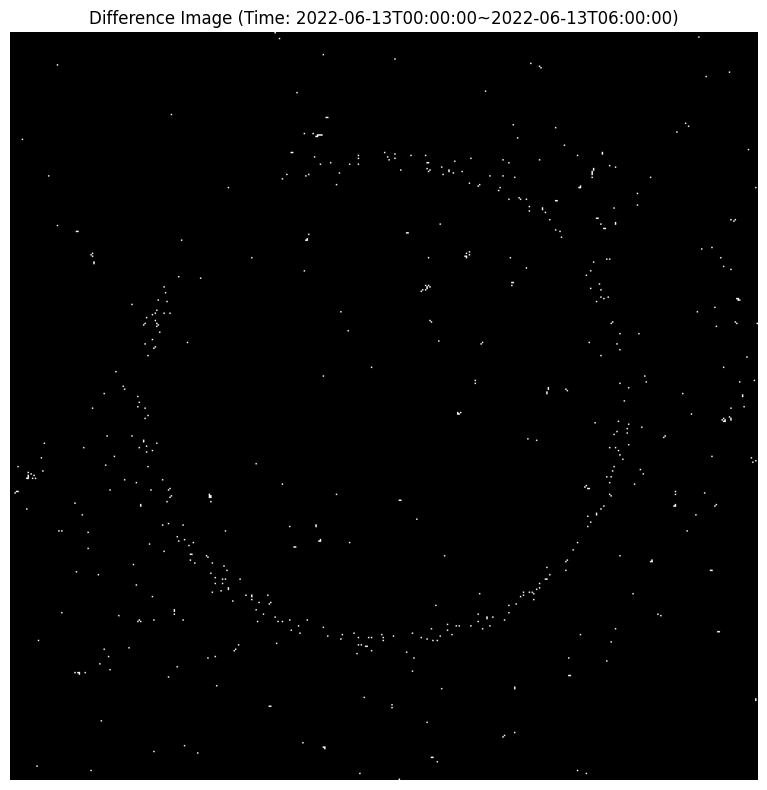

動画を作成中...
動画が作成されました: lasco_c2_diff.mp4


In [5]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as a
import sunpy.map
import warnings
from astropy.io.fits.verify import VerifyWarning

# astropy.io.fits の VerifyWarning を抑制
warnings.filterwarnings('ignore', category=VerifyWarning)

def generate_diff_video(start_time, end_time, video_filename, fps=10):
    """
    指定した開始時刻・終了時刻のSOHO/LASCO-C2データを取得し、
    クロップ後の画像同士の差分画像を計算、最初の差分画像をタイトルとカラーバー付きで表示した上で、
    動画（mp4）として保存する関数です。

    Parameters
    ----------
    start_time : str
        取得開始時刻（ISO形式の文字列）
    end_time : str
        取得終了時刻（ISO形式の文字列）
    video_filename : str
        出力する動画ファイル名（例: 'lasco_c2_diff.mp4'）
    fps : int, optional
        動画のフレームレート（デフォルトは10fps）
    """
    # ===== SOHO/LASCO-C2 のデータ検索 =====
    print("データを検索中...")
    result = Fido.search(a.Time(start_time, end_time),
                         a.Instrument('lasco'),
                         a.Detector('c2'))
    
    if len(result[0]) == 0:
        raise RuntimeError("指定した時間帯のSOHO/LASCO-C2データが見つかりませんでした．")
    print(f"見つかったファイル数: {len(result[0])}")
    
    # ===== データのダウンロード =====
    print("データをダウンロード中...")
    downloaded_files = Fido.fetch(result, progress=True)
    
    # ===== ダウンロードファイルの読み込み =====
    print("画像ファイルを読み込み中...")
    downloaded_files.sort()
    
    maps = []
    for file in downloaded_files:
        try:
            m = sunpy.map.Map(file)
            maps.append(m)
        except Exception as e:
            print(f"ファイル {file} の読み込みに失敗しました: {e}")
    
    if len(maps) < 2:
        raise RuntimeError("差分画像を作成するには2枚以上の画像が必要です．")
    
    # ===== 共通のサイズにクロップ =====
    shapes = [m.data.shape for m in maps]
    target_H = min(shape[0] for shape in shapes)
    target_W = min(shape[1] for shape in shapes)
    target_shape = (target_H, target_W)
    
    def crop_center(data, target_shape):
        """画像データを中央部分から target_shape (height, width) でクロップする"""
        H, W = data.shape
        target_H, target_W = target_shape
        start_H = (H - target_H) // 2
        start_W = (W - target_W) // 2
        return data[start_H:start_H+target_H, start_W:start_W+target_W]
    
    cropped_maps = []
    for m in maps:
        cropped_data = crop_center(m.data, target_shape)
        m_new = sunpy.map.Map(cropped_data, m.meta)
        cropped_maps.append(m_new)
    maps = cropped_maps
    
    # ===== 差分画像の計算 =====
    print("差分画像を作成中...")
    diff_images = []
    # 差分画像に対応する時間情報（後の画像の時刻）をリストに保存
    diff_times = []
    for i in range(1, len(maps)):
        diff = maps[i].data - maps[i-1].data
        
        diff_min = np.nanmin(diff)
        diff_max = np.nanmax(diff)
        if diff_max - diff_min == 0:
            norm_diff = np.zeros(diff.shape, dtype=np.uint8)
        else:
            norm_diff = 255 * (diff - diff_min) / (diff_max - diff_min)
            norm_diff = norm_diff.astype(np.uint8)
        
        diff_images.append(norm_diff)
        # タイトルに使うため、後の画像の観測時刻（date_obsなど）を取得
        # 以下はキー 'date-obs' または 'date_obs' がある場合を想定
        meta = maps[i].meta
        diff_time = meta.get('date-obs', meta.get('date_obs', ''))
        diff_times.append(diff_time)
    
    # ===== 差分画像の確認プロット =====
    # ここでは最初の差分画像に対して、タイトルにその時間を入れ、カラーバーの値を制御
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    im = ax.imshow(diff_images[0], cmap='gray', vmin=100, vmax=200)
    # タイトルに「差分画像」とともに、後の画像の時刻を表示
    title_time = diff_times[0] if diff_times[0] != '' else 'Unknown Time'
    ax.set_title(f"Difference Image (Time: {}~{end_time})")
    ax.axis('off')
    # カラーバーの目盛りを [0, 64, 128, 192, 255] に固定
    # cbar = plt.colorbar(im, ax=ax, ticks=[0, 64, 128, 192, 255])
    # cbar.set_label("Normalized Intensity")
    plt.show()
    
    # ===== 動画の作成 =====
    print("動画を作成中...")
    imageio.mimwrite(video_filename, diff_images, fps=fps, codec='libx264', format='ffmpeg')
    print("動画が作成されました:", video_filename)



# 例として、2022-06-13 の 00:00～06:00 のデータを対象に動画作成
generate_diff_video('2022-06-13T00:00:00', '2022-06-13T06:00:00', 'lasco_c2_diff.mp4', fps=5)


# 画像から動画を作成

In [2]:
import os
import glob
import imageio.v2 as imageio

# 画像が保存されているディレクトリとファイル名パターン
image_dir = "/home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW"
# 例として、"_lasc2rdf_aia193rdf.png" がファイル名に含まれる画像を対象とする
pattern = os.path.join(image_dir, "*_lasc2rdf_aia193rdf.png")
image_files = sorted(glob.glob(pattern))

if not image_files:
    raise RuntimeError(f"パターンに一致する画像が見つかりません: {pattern}")

print(f"見つかった画像数: {len(image_files)}")

# 各画像を読み込み
frames = []
for file in image_files:
    print(f"読み込み中: {file}")
    frame = imageio.imread(file)
    frames.append(frame)

# 出力動画のファイル名とフレームレートの設定
video_filename = "SOHO-LASCO-C2_difference_CDAW_video.mp4"
fps = 5  # 例：1秒間に10フレーム

# 動画の作成
print("動画を作成中...")
imageio.mimwrite(video_filename, frames, fps=fps, codec='libx264', format='ffmpeg')
print("動画が作成されました:", video_filename)


見つかった画像数: 18
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_022405_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_023607_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_024805_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_031211_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_032405_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_033605_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_034806_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_040005_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/SOHO/LASCO-C2_AIA_image_from_CDAW/20220613_041205_lasc2rdf_aia193rdf.png
読み込み中: /home/kinno-7010/Research/